In [82]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import scipy.signal
import rasterio
import rasterio.features
from rasterio import MemoryFile
from affine import Affine
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from scipy.ndimage import gaussian_filter
from shapely.geometry import Polygon, shape
import subprocess as sp

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

## Read rasters and clean data

In [95]:
S3R = S3Helper('roof-index')

# Read rasters
height = S3R.read_tif_from_s3_as_rio("missoula/geospatial/downtown_height.tif" ) 
slope = S3R.read_tif_from_s3_as_rio("missoula/geospatial/downtown_slope.tif" ) 

# Smooth noise in height raster
smoothed = gaussian_filter(height.read(1), sigma=0.5)

# Convert slope to flat areas according to threshold 
flat = np.where(slope.read(1) <= 15, 1, 0)

# Multiply two arrays to get height pixels that are flat
merged = flat * smoothed

# Filter out pixels shorter than 5 feet (because they likely aren't buildings)
merged = np.where(merged < 5, 0, merged)

arr = merged
meta = height.meta

## Polygonize the raster using  GDAL

In [96]:
def polygonize(arr, meta):
    temp = 'temp'
    if not os.path.isdir(temp):
        print('Making temporary directory.')
        os.mkdir(temp)

    # Write raster to temp directory
    f = os.path.join(temp, 'flat_tmp.tif')
    out = rasterio.open(f, 'w', **meta)
    out.write(arr[np.newaxis].astype(np.float32))
    out.close()

    # Polygonize and return shapefile
    sp.call(['gdal_polygonize.py', f, os.path.join(temp, 'polys.shp')])
    flat_vec = gpd.read_file(os.path.join(temp, 'polys.shp'))
    flat_vec = flat_vec[flat_vec['DN'] != 0]
    
    shutil.rmtree(temp)

    return flat_vec

In [109]:
bldgs_path = "missoula/geospatial/downtown_flat_beta.zip"
bldgs = S3R.read_shp_from_s3_as_gpd(bldgs_path).to_crs(6514)
bldgs = bldgs[bldgs['flat'] == 1]

Making temporary directory.


<AxesSubplot:>

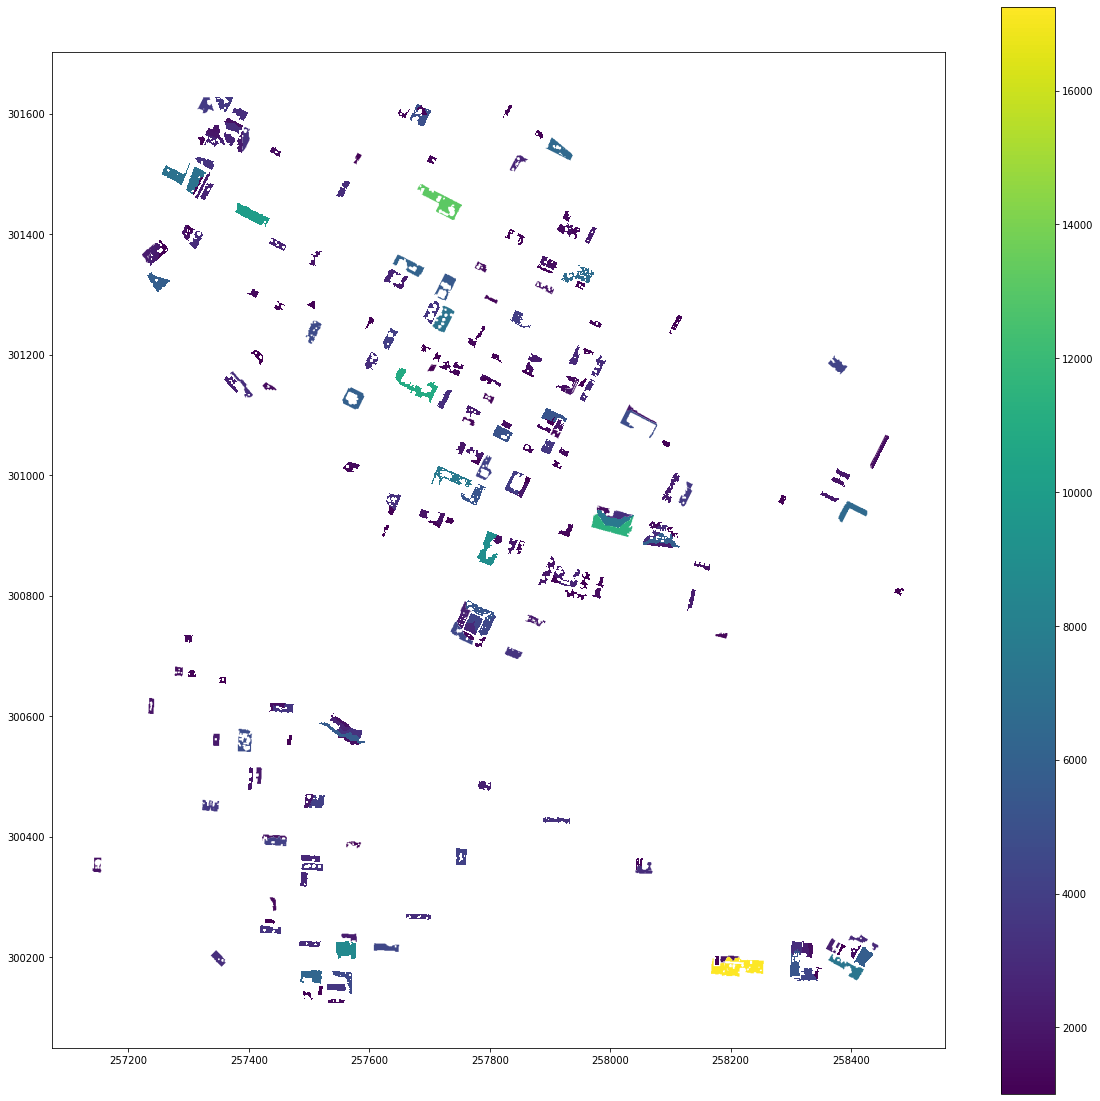

In [110]:
flat_test = polygonize(arr, meta)

# Spatial join of buildings and flat areas
joined = gpd.overlay(flat_vec, bldgs, how='intersection')
joined = joined.drop(columns='DN')

# Filter buildings with an area smaller than 1000 Sq. Ft.
joined['area'] = joined['geometry'].area  * 10.7639
joined = joined[joined['area'] > 1000]
fig, ax = plt.subplots(1,1, figsize=(20,20))
joined.plot(column='area', ax=ax, legend=True)

In [111]:
# S3R.write_gdf_to_s3(joined, 'missoula/geospatial/contiguous_flat.zip')

contiguous_flat.zip has been successfully written to your S3 bucket.
